<h1><center> Visualization <br><br>
    <center> Wendy Shi

## TOC

- [Preparation](#Preparation)
- [Home Location](#Home-location)
- [Jump length](#Jump-Length)
- [Summary Statistics](#Summary-statistics)
- [Funcations](#Function)

# Preparation

In [2]:
#skmob
import skmob
import geopandas as gpd
from skmob.models.epr import DensityEPR
from skmob.measures.individual import home_location
from skmob.measures.individual import jump_lengths

#standard
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.interpolate import interp1d
import scipy.stats as stats

#visualization
import seaborn as sns

#Geopandas related
import fiona
from shapely.geometry import shape

## Subsetting

In [3]:
#Load data
node_dict = pd.read_csv("../Data/nodes_considered.csv")

#Standardize GEOID
node_dict["GEO_ID"] = node_dict["GEO_ID"].apply(lambda x: f"{int(x):05d}") #turn GEOID into 6 digit format

#rename column
rename = {'GEO_ID' : 'GEOID'}
node_dict = node_dict.rename(columns = rename)

#State ID: Add a new column
node_dict['State'] = node_dict['GEOID'].str[:2]
node_dict.head(3)

,index,GEOID,State
0,0,01001,01
1,1,01003,01
2,2,01005,01


In [4]:
#print out the number of States that we want
CA = node_dict[node_dict['State'] == '06']
print(CA.shape)
CA.head(3)

(55, 3)


,index,GEOID,State
133,133,06001,06
134,134,06005,06
135,135,06007,06


## US Shape File

In [5]:
shape_file = pd.read_csv("../Data/us_shapefile_county.csv")
shape_file.head(3)

,GEO_ID,STATE,COUNTY,NAME,LSAD,CENSUSAREA,State_1,Alpha code,Region,Division,CDC region,FIPS code,2013 code,U/R,pop2020,pop2021
0,48301,48,301,Loving,County,668.925,Texas,TX,South,West South Central,6.0,48301,6,R,67.0,57.0
1,48269,48,269,King,County,910.872,Texas,TX,South,West South Central,6.0,48269,6,R,270.0,258.0
2,48261,48,261,Kenedy,County,1458.329,Texas,TX,South,West South Central,6.0,48261,5,R,346.0,340.0


In [6]:
#Check how many state does NY has in total
CA_sub = shape_file[shape_file['State_1'] == 'California']
print(CA_sub.shape)
CA_sub.head(3)

(58, 16)


,GEO_ID,STATE,COUNTY,NAME,LSAD,CENSUSAREA,State_1,Alpha code,Region,Division,CDC region,FIPS code,2013 code,U/R,pop2020,pop2021
41,6003,6,3,Alpine,County,738.332,California,CA,West,Pacific,9.0,6003,6,R,1198.0,1235.0
185,6091,6,91,Sierra,County,953.214,California,CA,West,Pacific,9.0,6091,6,R,3228.0,3283.0
606,6049,6,49,Modoc,County,3917.770,California,CA,West,Pacific,9.0,6049,6,R,8658.0,8661.0


In [7]:
CA_name_id_pop = shape_file[(shape_file["STATE"] == 6) & (shape_file["pop2020"] > 11000)] 

rename = {"GEO_ID" : "GEOID"}
CA_name_id_pop = CA_name_id_pop.rename(columns = rename)
CA_name_id_pop = CA_name_id_pop[['GEOID', 'NAME','LSAD','STATE','State_1','pop2020']]
CA_name_id_pop['GEOID'] = CA_name_id_pop['GEOID'].apply(lambda x: f"{int(x):05d}") 
print(CA_name_id_pop.shape)
CA_name_id_pop.head()

(55, 6)


,GEOID,NAME,LSAD,STATE,State_1,pop2020
917,06051,Mono,County,6,California,13206.0
1089,06105,Trinity,County,6,California,16088.0
1158,06043,Mariposa,County,6,California,17124.0
1248,06027,Inyo,County,6,California,19023.0
1288,06063,Plumas,County,6,California,19769.0


In [8]:
CA_name_id_pop.info()

<class 'pandas.core.frame.DataFrame'>
Index: 55 entries, 917 to 3106
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   GEOID    55 non-null     object 
 1   NAME     55 non-null     object 
 2   LSAD     55 non-null     object 
 3   STATE    55 non-null     int64  
 4   State_1  55 non-null     object 
 5   pop2020  55 non-null     float64
dtypes: float64(1), int64(1), object(4)
memory usage: 3.0+ KB


In [9]:
CA_name_id_pop['GEOID'] = CA_name_id_pop['GEOID'].astype(str)
county_list = CA_name_id_pop['GEOID'].tolist()
print(len(county_list))

55


#

# Population Districts 
- Tracts, Block Groups and Blocks

## Census Block Group

In [13]:
data = []

with fiona.open("tl_2020_06_bg/tl_2020_06_bg.shp") as src:
    for feature in src:
        row = dict(feature['properties'])        # convert to dict
        row['geometry'] = shape(feature['geometry'])  # shapely geometry
        data.append(row)

ca_bg_df = pd.DataFrame(data)

ca_bg_sf = gpd.GeoDataFrame(ca_bg_df, geometry='geometry')
ca_bg_sf.head(3) 

,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,06,053,001500,1,060530015001,Block Group 1,G5030,S,3348560,0,+36.6564570,-121.6749086,"POLYGON ((-121.69184 36.65885, -121.68510 36.6..."
1,06,073,002712,2,060730027122,Block Group 2,G5030,S,337744,0,+32.7303521,-117.0787620,"POLYGON ((-117.08306 32.72588, -117.08280 32.7..."
2,06,073,018601,2,060730186012,Block Group 2,G5030,S,886725,0,+33.2295683,-117.3482855,"POLYGON ((-117.35296 33.22489, -117.35294 33.2..."


In [14]:
#url = "https://www2.census.gov/geo/tiger/TIGER2021/BG/tl_2021_35_bg.zip"
#ny_bg_sf = gpd.read_file(url)
#print(ny_bg_sf.columns)
#print(ny_bg_sf.shape)
#ny_bg_sf.head(1) 

## Test: Accquiring Census Block Group Population Data


- For New York census block group population data specifically, you can follow these steps:

- Go to https://data.census.gov/
- In the search bar, type "population"
- Under "Geography," select "Block Group"
- Then select "New York" as the state
- Choose the counties and block groups you're interested in
- Select the appropriate ACS 5-Year Estimates table (the latest available would be best)

For population data specifically, look for table B01003 "Total Population" which gives you the basic population count.

If you want to get Decennial Census Data, Do the same thing and look for Decennial Census, look for P1 Data

In [11]:
bg_pop = pd.read_csv("ACSDT5Y2020/ACSDT5Y2020.B01003-Data.csv")
bg_pop = bg_pop.drop(index=bg_pop.index[0]) #drop the first row
print(bg_pop.shape)
bg_pop.head(3)

(25607, 5)


,GEO_ID,NAME,B01003_001E,B01003_001M,Unnamed: 4
1,1500000US060014001001,"Block Group 1, Census Tract 4001, Alameda Coun...",1713,359,NaN
2,1500000US060014001002,"Block Group 2, Census Tract 4001, Alameda Coun...",1322,221,NaN
3,1500000US060014002001,"Block Group 1, Census Tract 4002, Alameda Coun...",940,155,NaN


In [12]:
bg_pop = bg_pop[['GEO_ID', 'B01003_001E']].copy()
rename = {'B01003_001E' : 'Population'}
bg_pop  = bg_pop.rename(columns = rename)
bg_pop.head(3)

,GEO_ID,Population
1,1500000US060014001001,1713
2,1500000US060014001002,1322
3,1500000US060014002001,940


In [19]:
bg_pop['Population'] = bg_pop['Population'].astype(int)
sum_value = bg_pop['Population'].sum()
print(sum_value)

39346023


In [20]:
bg_pop['GEOID'] = bg_pop['GEO_ID'].str[-12:]
bg_pop.head(3)

,GEO_ID,Population,GEOID
1,1500000US060014001001,1713,060014001001
2,1500000US060014001002,1322,060014001002
3,1500000US060014002001,940,060014002001


In [21]:
bg_pop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25607 entries, 1 to 25607
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   GEO_ID      25607 non-null  object
 1   Population  25607 non-null  int64 
 2   GEOID       25607 non-null  object
dtypes: int64(1), object(2)
memory usage: 600.3+ KB


In [27]:
bg_pop = bg_pop[['GEOID', 'Population']].copy()
bg_pop['COUNTY'] = bg_pop['GEOID'].str[:5]
bg_pop_new = bg_pop[bg_pop['COUNTY'].isin(county_list)]
print(bg_pop_new.shape)
bg_pop_new.head()

(25590, 3)


,GEOID,Population,COUNTY
1,060014001001,1713,06001
2,060014001002,1322,06001
3,060014002001,940,06001
4,060014002002,1043,06001
5,060014003001,1206,06001


## Merge Data

In [28]:
tessellation = pd.merge(ca_bg_sf, bg_pop_new, on = 'GEOID', how = 'inner')
print(tessellation.shape)
tessellation.head(3)

(25590, 15)


,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,Population,COUNTY
0,06,053,001500,1,060530015001,Block Group 1,G5030,S,3348560,0,+36.6564570,-121.6749086,"POLYGON ((-121.69184 36.65885, -121.68510 36.6...",1660,06053
1,06,073,002712,2,060730027122,Block Group 2,G5030,S,337744,0,+32.7303521,-117.0787620,"POLYGON ((-117.08306 32.72588, -117.08280 32.7...",2060,06073
2,06,073,018601,2,060730186012,Block Group 2,G5030,S,886725,0,+33.2295683,-117.3482855,"POLYGON ((-117.35296 33.22489, -117.35294 33.2...",1845,06073


In [29]:
len(tessellation['COUNTYFP'].unique())

55

#

# Individual Trajectory Generation

In [30]:
tessellation = tessellation[['GEOID', 'Population', 'geometry']].copy()
tessellation = tessellation.loc[tessellation['Population'] != 0].copy()
print(tessellation.info())
tessellation.head(3)

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 25496 entries, 0 to 25589
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   GEOID       25496 non-null  object  
 1   Population  25496 non-null  int64   
 2   geometry    25496 non-null  geometry
dtypes: geometry(1), int64(1), object(1)
memory usage: 796.8+ KB
None


,GEOID,Population,geometry
0,060530015001,1660,"POLYGON ((-121.69184 36.65885, -121.68510 36.6..."
1,060730027122,2060,"POLYGON ((-117.08306 32.72588, -117.08280 32.7..."
2,060730186012,1845,"POLYGON ((-117.35296 33.22489, -117.35294 33.2..."


## Density EPR

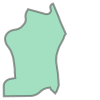

In [32]:
tessellation.iloc[2,2]

### This Takes 3 hours to run

In [49]:
start_time = pd.to_datetime('2020/03/01 00:00:00')
end_time = pd.to_datetime('2020/03/30 23:59:59')
depr = DensityEPR()
tdf = depr.generate(start_time, 
                    end_time, 
                    tessellation, 
                    relevance_column='Population', #Take population into account
                    n_agents=10000, 
                    show_progress=True)

/Users/wendyshi2001/anaconda3/envs/skmob/lib/python3.9/site-packages/geopandas/geoseries.py:574: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
  0%|                                                 | 0/10000 [00:00<?, ?it/s]/Users/wendyshi2001/anaconda3/envs/skmob/lib/python3.9/site-packages/skmob/models/gravity.py:43: RuntimeWarning: divide by zero encountered in power
  return np.power(x, exponent)
100%|███████████████████████████████████| 10000/10000 [2:05:53<00:00,  1.32it/s]


In [50]:
tdf.to_csv("CA_4Week_10000_realpop.csv")

#

#

# Visualizations

In [51]:
#data = ditras_tdf
data = tdf
person1 = data[data["uid"] == 1].copy().reset_index()
person1 = person1.drop(columns = 'index')
print(person1.shape)
person1.head(5)

(490, 4)


,uid,datetime,lat,lng
0,1,2020-03-01 00:00:00.000000,33.984984,-118.177562
1,1,2020-03-01 00:36:55.336052,33.983342,-118.180459
2,1,2020-03-01 01:38:39.853429,33.982892,-118.173715
3,1,2020-03-01 02:04:41.900006,33.984984,-118.177562
4,1,2020-03-01 02:36:01.651631,34.031512,-118.222886


In [52]:
plotting_data = skmob.TrajDataFrame(person1, latitude='lat', datetime='datetime', user_id='uid')

plotting_data.plot_trajectory(
    zoom=12,
    weight=3,
    opacity=0.9,
    max_users = 1,
    max_points=None, #trajectories will be down-sampled to have at most `max_points` points.
    tiles='OpenStreetMap'  # Built-in tile set, no attribution needed
)

#

# Home location

In [53]:
# now create a TrajDataFrame from the pandas DataFrame
#tdf = skmob.TrajDataFrame(data, latitude='lat', datetime='datetime', user_id='uid')
print(tdf.shape)
tdf.head(5)

(4689466, 4)


,uid,datetime,lat,lng
0,1,2020-03-01 00:00:00.000000,33.984984,-118.177562
1,1,2020-03-01 00:36:55.336052,33.983342,-118.180459
2,1,2020-03-01 01:38:39.853429,33.982892,-118.173715
3,1,2020-03-01 02:04:41.900006,33.984984,-118.177562
4,1,2020-03-01 02:36:01.651631,34.031512,-118.222886


In [54]:
hl_df = home_location(tdf)
hl_df.head(5)

100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1613.98it/s]


,uid,lat,lng
0,1,33.983342,-118.180459
1,2,33.838065,-118.219024
2,3,34.080243,-116.205548
3,4,37.923568,-122.085091
4,5,34.033587,-118.449005


In [55]:
hl_df.to_csv("Home_location_4Week_10000_CA_realpop.csv")